# Open University Dataset 

## Dataset Characteristics

**Has GROUPING field**

* What defines a topic here? [Code Module] or [Code Module + Code Presentation]  
  **From the paper**: 'The structure of B and J presentations may differ and therefore it is recommended to analyse the B and J presentations separately.'
  It could also be the case that a student is redoing a certain module -> in combination with the limited timestamp this could lead to mixed up interactions -> better to separate modules and presentation

* Should only users that finished a particular module be included -> better to include all to have 'failing learning paths'

* The timestamp is ordering student interactions by days. Within days the predefined order needs to be taken as is.

* Assessments are given several times during modules and as final grades at the end of the module. Here we will focus on the final grades! There is no assessment score per interaction.

* Should the activity types be filtered by content? Since all activities lead to the achievement of a certain learning goal, no filter is applied.

* The date field was modfied by decimal points in increasing order per user per day to allow an unique ordering of interactions. 

## Preliminaries

### Constants

In [2]:
# paths
PATH_TO_INTERACTION_DATA = '../../../../../../data/ddia/open_university/anonymisedData/studentVle.csv'
PATH_TO_VLE_DATA = '../../../../../../data/ddia/open_university/anonymisedData/vle.csv'
PATH_TO_STUDENT_DEMOGRAPHIC_DATA = '../../../../../../data/ddia/open_university/anonymisedData/studentInfo.csv'

# dataset name
DATASET_NAME = 'open_university'

# fields used in the analysis
USER_FIELD = 'id_student'
GROUP_FIELD = 'id_module'
LEARNING_ACTIVITY_FIELD = 'id_site'

# fields used in dataset preparation
TIMESTAMP_FIELD = 'custom_timestamp'
OLD_TIMESTAMP_FIELD = 'date'
MODULE_FIELD = 'code_module'
PRESENTATION_FIELD = 'code_presentation'
ACTIVITY_TYPE_FIELD = 'activity_type'
FINAL_RESULT_FIELD = 'final_result'

### Import Packages

In [3]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import textdistance as td
import pickle

### Seaborn Configuration

In [4]:
sns.set(rc = {'figure.figsize':(15,8)})

In [5]:
#sns.set_context("notebook", rc={"font.size":20,"axes.titlesize":30,"axes.labelsize":20, "xtick.labelsize":16, "ytick.labelsize":16, "legend.fontsize":20, "legend.title_fontsize":20})   

In [6]:
sns.set_style("darkgrid")

In [7]:
marker_config = {"marker":"o",
                 "markerfacecolor":"white", 
                 "markeredgecolor":"black",
                 "markersize":"10"}

### Import Pickled Objects

In [8]:
# with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PER_GROUP_PICKLE_NAME, 'rb') as f:
#     seq_dist_per_group_dict = pickle.load(f)

# with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PICKLE_NAME, 'rb') as f:
#     seq_dist_dict = pickle.load(f)

## Functions

In [9]:
def merge_columns(dataframe: pd.DataFrame, col_1: str, col_2: str, merged_col_name: str):
    """Merges two columns of dataframe together

    Parameters
    ----------
    dataframe : pd.DataFrame
        A pandas dataframe
    col_1 : str
        The field name of the first column
    col_2 : str
        The field name of the second column
    merged_col_name : str
        The name of the merged 

    Returns
    -------
    _type_
        _description_
    """
    new_series = dataframe[col_1] + '_' + dataframe[col_2]
    dataframe = dataframe.drop([col_1, col_2], axis=1)

    dataframe[merged_col_name] = new_series

    return dataframe


def add_new_ascending_integers_timestamp_per_group_user_comb(interactions: pd.DataFrame, group_field: str, user_field: str, new_timestamp_field: str):
    """Add a new timestamp field to the interactions dataframe that consists of ascending integers (start=1) for all group-user pairs

    Parameters
    ----------
    interacions : pd.DataFrame
        The interactions dataframe
    group_field : str
        The group field column
    user_field : str
        The user field column
    new_timestamp_field : str
        The new timestamp field column

    Returns
    -------
    pd.DataFrame
        A dataframe that has a new timestamp field which consists of ascending integers (start=1) for all group user pairs
    """
    new_timestamp_list = []
    new_index_list = []

    for group, df in interactions.groupby([group_field, user_field]):
        length_df = len(df) 
        new_timestamp = list(range(1, length_df+1, 1)) 
        index = df.index
        
        new_timestamp_list.extend(new_timestamp)
        new_index_list.extend(index)

    new_timestamp_series = pd.Series(new_timestamp_list, index=new_index_list, name=new_timestamp_field)

    interactions = interactions.merge(new_timestamp_series, left_index=True, right_index=True)

    return interactions

## Dataset Preparation

### Import Data

In [10]:
interactions = pd.read_csv(PATH_TO_INTERACTION_DATA)
learning_materials = pd.read_csv(PATH_TO_VLE_DATA)
student_demographics = pd.read_csv(PATH_TO_STUDENT_DEMOGRAPHIC_DATA)

In [11]:
interactions

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
...,...,...,...,...,...,...
10655275,GGG,2014J,675811,896943,269,3
10655276,GGG,2014J,675578,896943,269,1
10655277,GGG,2014J,654064,896943,269,3
10655278,GGG,2014J,654064,896939,269,1


In [12]:
learning_materials['week_from'].value_counts()

18.0    91
1.0     84
28.0    63
9.0     52
21.0    51
27.0    49
11.0    47
15.0    46
29.0    45
20.0    43
2.0     41
10.0    40
22.0    38
8.0     36
3.0     35
23.0    33
5.0     33
24.0    33
14.0    32
13.0    31
26.0    30
19.0    29
16.0    27
12.0    26
4.0     24
25.0    24
6.0     17
7.0     15
17.0     4
0.0      2
Name: week_from, dtype: int64

In [15]:
learning_materials['activity_type'].value_counts()

resource          2660
subpage           1055
oucontent          996
url                886
forumng            194
quiz               127
page               102
oucollaborate       82
questionnaire       61
ouwiki              49
dataplus            28
externalquiz        26
homepage            22
ouelluminate        21
glossary            21
dualpane            20
repeatactivity       5
htmlactivity         4
sharedsubpage        3
folder               2
Name: activity_type, dtype: int64

In [12]:
student_demographics

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...
32588,GGG,2014J,2640965,F,Wales,Lower Than A Level,10-20,0-35,0,30,N,Fail
32589,GGG,2014J,2645731,F,East Anglian Region,Lower Than A Level,40-50%,35-55,0,30,N,Distinction
32590,GGG,2014J,2648187,F,South Region,A Level or Equivalent,20-30%,0-35,0,30,Y,Pass
32591,GGG,2014J,2679821,F,South East Region,Lower Than A Level,90-100%,35-55,0,30,N,Withdrawn


### Merge and Filter Data

In [13]:
interactions = merge_columns(interactions, MODULE_FIELD, PRESENTATION_FIELD, GROUP_FIELD)
student_demographics = merge_columns(student_demographics, MODULE_FIELD, PRESENTATION_FIELD, GROUP_FIELD)
interactions = add_new_ascending_integers_timestamp_per_group_user_comb(interactions, GROUP_FIELD, USER_FIELD, TIMESTAMP_FIELD)
interactions = interactions.merge(learning_materials[[LEARNING_ACTIVITY_FIELD, ACTIVITY_TYPE_FIELD]], how="left", on=LEARNING_ACTIVITY_FIELD)
interactions = interactions.merge(student_demographics[[GROUP_FIELD, USER_FIELD, FINAL_RESULT_FIELD]], how="left", on=[GROUP_FIELD, USER_FIELD])

In [14]:
interactions

,id_student,id_site,date,sum_click,id_module,custom_timestamp,activity_type,final_result
0,28400,546652,-10,4,AAA_2013J,1,forumng,Pass
1,28400,546652,-10,1,AAA_2013J,2,forumng,Pass
2,28400,546652,-10,1,AAA_2013J,3,forumng,Pass
3,28400,546614,-10,11,AAA_2013J,4,homepage,Pass
4,28400,546714,-10,1,AAA_2013J,5,oucontent,Pass
...,...,...,...,...,...,...,...,...
10655275,675811,896943,269,3,GGG_2014J,794,homepage,Distinction
10655276,675578,896943,269,1,GGG_2014J,368,homepage,Pass
10655277,654064,896943,269,3,GGG_2014J,434,homepage,Pass
10655278,654064,896939,269,1,GGG_2014J,435,forumng,Pass


### Filter Sequences by NAs in Dataset 

In [14]:
# only timestamps contain NAs
pct_na = get_nas_in_data(interactions)
pct_na

id_student          0.0 %
id_site             0.0 %
date                0.0 %
sum_click           0.0 %
id_module           0.0 %
custom_timestamp    0.0 %
activity_type       0.0 %
final_result        0.0 %
dtype: object

In [15]:
interactions = drop_na_by_fields(interactions, field_list=[GROUP_FIELD, USER_FIELD, LEARNING_ACTIVITY_FIELD, TIMESTAMP_FIELD])

Input length: 10655280
Outpunt length: 10655280
Number of rows removed: 0
Percentage of rows removed: 0%


### Sort by Timestamp

In [16]:
interactions = sort_by_timestamp(interactions, TIMESTAMP_FIELD, higher_level_sort_list=[GROUP_FIELD, USER_FIELD])

### Transform Data

In [17]:
interactions = keep_last_repeated_learning_activities(interactions, GROUP_FIELD, USER_FIELD, LEARNING_ACTIVITY_FIELD, TIMESTAMP_FIELD)

100%|██████████| 29228/29228 [00:12<00:00, 2415.92it/s]


Initial number of interactions: 10655280
Final number of interactions: 9526098
Removed number of interactions: 1129182
Removed percentage of interactions: 10.597393968060905%


## Summary Statistics and Plots 

In [18]:
print_summary_stats(interactions, USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD, USER_FIELD_NAME_STR, GROUP_FIELD_NAME_STR, LEARNING_ACTIVITY_FIELD_NAME_STR, has_group_field=True)

number of interactions: 9526098
number of unique Topics: 22
number of unique Users: 26074
number of unique Learning Resources: 6268


### Dataset Specific Characteristics

### Interactions per User

In [19]:
interactions_per_user = print_and_return_interactions_per_user(interactions, USER_FIELD, USER_FIELD_NAME_STR)

mean number of interactions per User: 365.3485464447342
median number of interactions per User: 234.0
max number of interactions per User: 5831
min number of interactions per User: 1


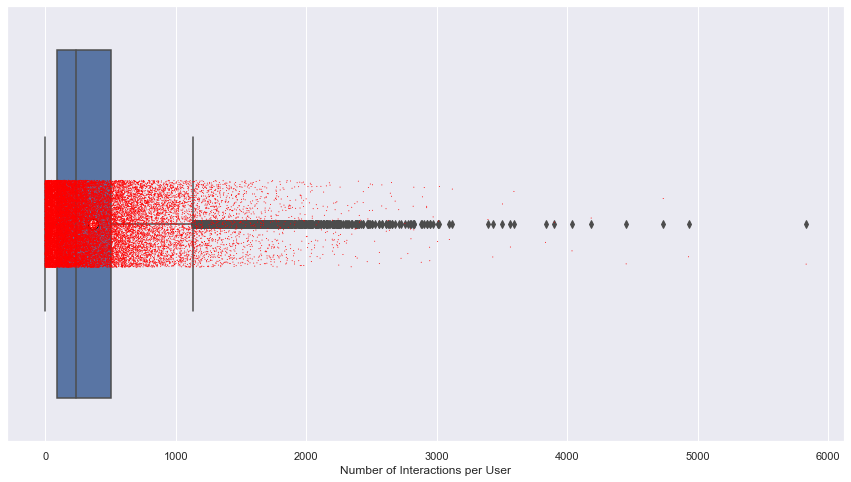

In [20]:
g = sns.boxplot(data=interactions_per_user, x='number of interactions', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=interactions_per_user, x='number of interactions', size=1, color="red");
g.set(xlabel='Number of Interactions per User');

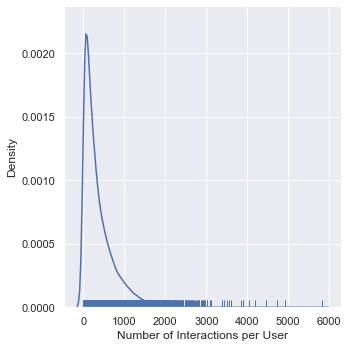

In [21]:
g = sns.displot(data=interactions_per_user, x='number of interactions', log_scale=False, kind='kde', rug=True)
g.set(xlabel='Number of Interactions per User');

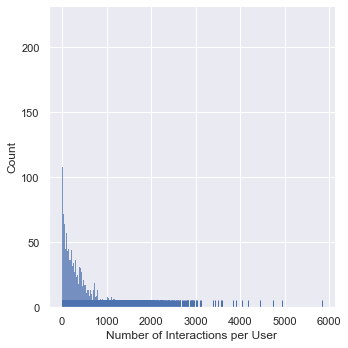

In [22]:
g = sns.displot(data=interactions_per_user, x='number of interactions', log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel='Number of Interactions per User');

### Number of Unique Groups per User

In [23]:
n_unique_groups_per_user = print_and_return_unique_col2_per_col1(interactions, USER_FIELD, GROUP_FIELD, NUMBER_UNIQUE_GROUPS_PER_USER_STR)

mean Number of Unique Topics per User: 1.1209634118278744
median Number of Unique Topics per User: 1.0
max Number of Unique Topics per User: 5
min Number of Unique Topics per User: 1


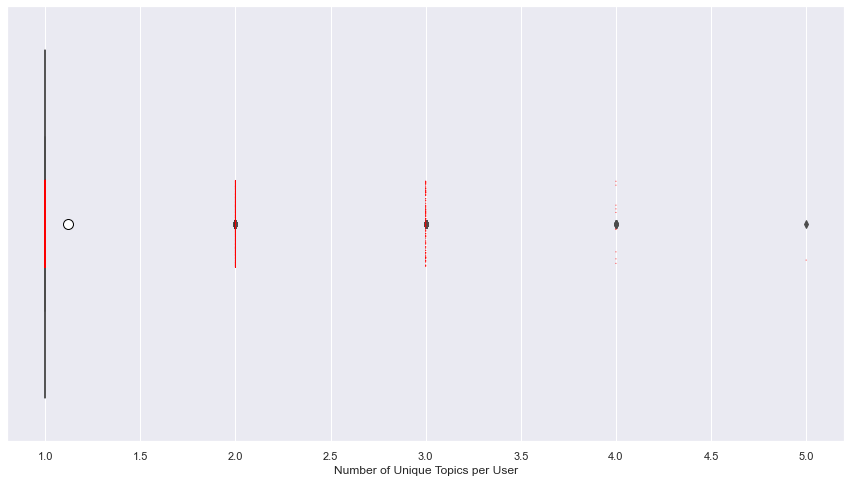

In [24]:
g = sns.boxplot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_GROUPS_PER_USER_STR);

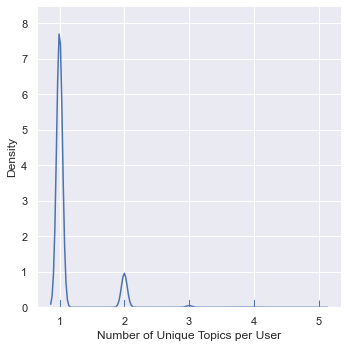

In [25]:
g = sns.displot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_GROUPS_PER_USER_STR);

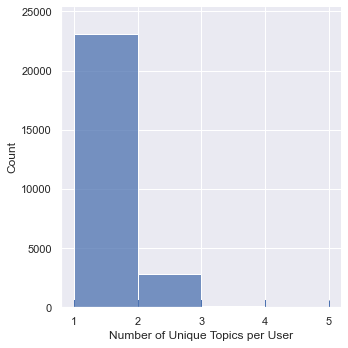

In [26]:
g = sns.displot(data=n_unique_groups_per_user, x=NUMBER_UNIQUE_GROUPS_PER_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=NUMBER_UNIQUE_GROUPS_PER_USER_STR);

### Number of Unique Learning Activities per User

In [27]:
n_unique_learning_activities_per_user = print_and_return_unique_col2_per_col1(interactions, USER_FIELD, LEARNING_ACTIVITY_FIELD, NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR)

mean Number of Unique Learnig Resources per User: 75.18969087980363
median Number of Unique Learnig Resources per User: 56.0
max Number of Unique Learnig Resources per User: 579
min Number of Unique Learnig Resources per User: 1


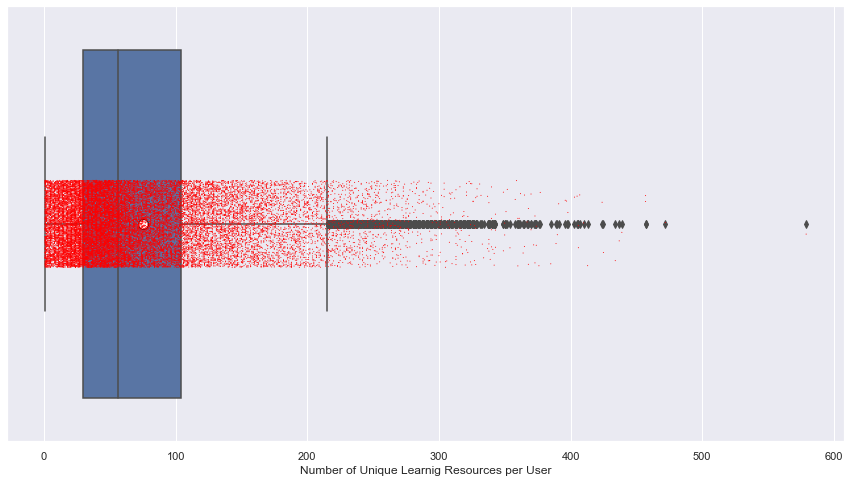

In [28]:
g = sns.boxplot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR);

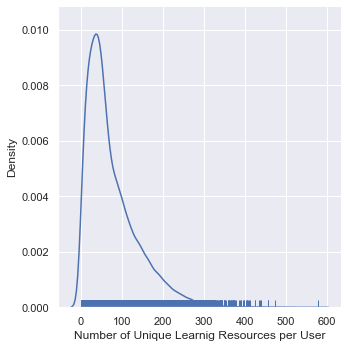

In [29]:
g = sns.displot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR);

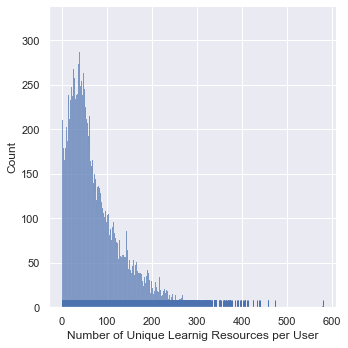

In [30]:
g = sns.displot(data=n_unique_learning_activities_per_user, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_USER_STR);

### Number of Unique Users per Group

In [31]:
n_unique_users_per_group = print_and_return_unique_col2_per_col1(interactions, GROUP_FIELD, USER_FIELD, NUMBER_UNIQUE_USERS_PER_GROUP_STR)

mean Number of Unique Users per Topic: 1328.5454545454545
median Number of Unique Users per Topic: 1328.5
max Number of Unique Users per Topic: 2302
min Number of Unique Users per Topic: 357


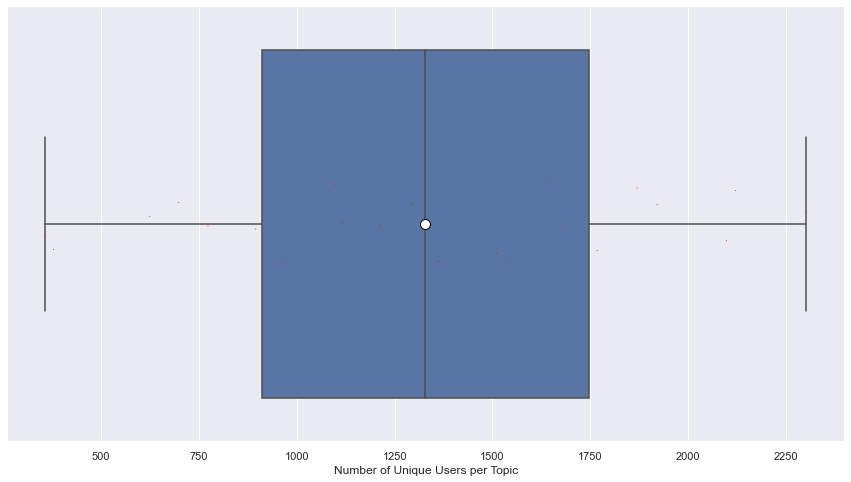

In [32]:
g = sns.boxplot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_GROUP_STR);

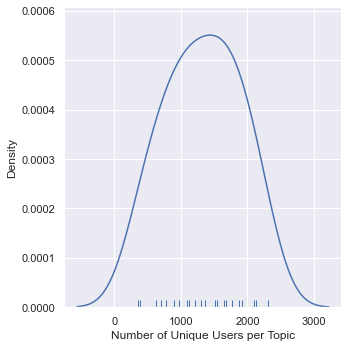

In [33]:
g = sns.displot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_GROUP_STR);

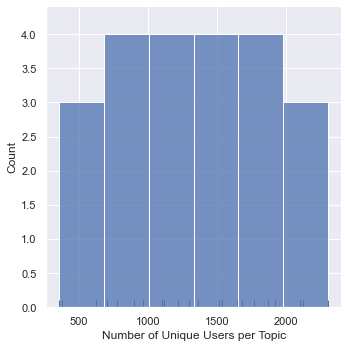

In [34]:
g = sns.displot(data=n_unique_users_per_group, x=NUMBER_UNIQUE_USERS_PER_GROUP_STR, log_scale=False, kind='hist', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_GROUP_STR);

### Number of Unique Learning Activities per Group

In [35]:
n_unique_learning_activities_per_group = print_and_return_unique_col2_per_col1(interactions, GROUP_FIELD, LEARNING_ACTIVITY_FIELD, NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR)

mean Number of Unique Learnig Resources per Topic: 284.90909090909093
median Number of Unique Learnig Resources per Topic: 265.5
max Number of Unique Learnig Resources per Topic: 526
min Number of Unique Learnig Resources per Topic: 104


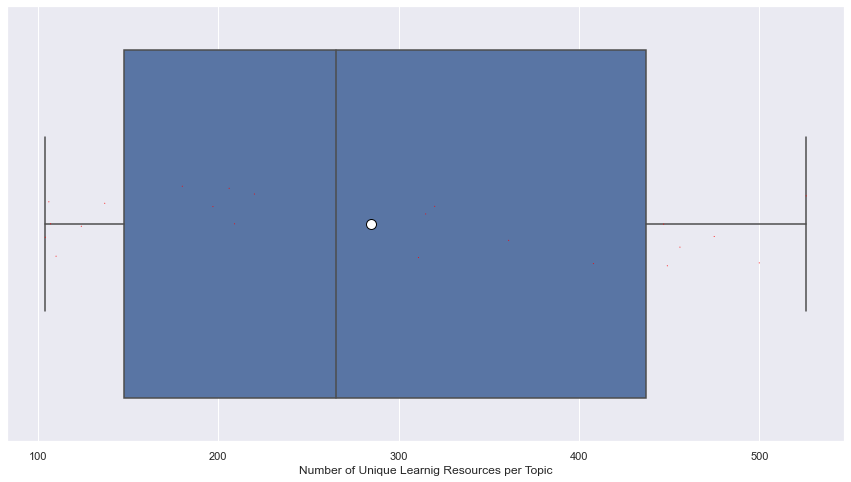

In [36]:
g = sns.boxplot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR);

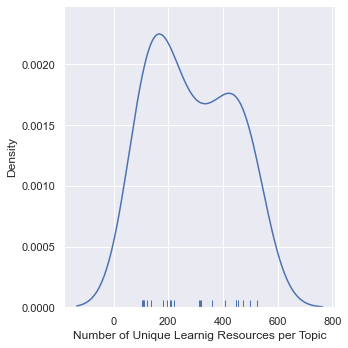

In [37]:
g = sns.displot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR);

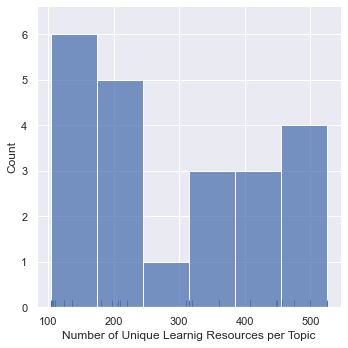

In [38]:
g = sns.displot(data=n_unique_learning_activities_per_group, x=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR, log_scale=False, kind='hist', rug=True)
g.set(xlabel=NUMBER_UNIQUE_LEARNING_ACTIVITIES_PER_GROUP_STR);

### Number of Unique Users per Learning Activity

In [39]:
n_unique_users_per_learning_activity = print_and_return_unique_col2_per_col1(interactions, LEARNING_ACTIVITY_FIELD, USER_FIELD, NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR)

mean Number of Unique Users per Learnig Resource: 312.7785577536694
median Number of Unique Users per Learnig Resource: 152.0
max Number of Unique Users per Learnig Resource: 2300
min Number of Unique Users per Learnig Resource: 1


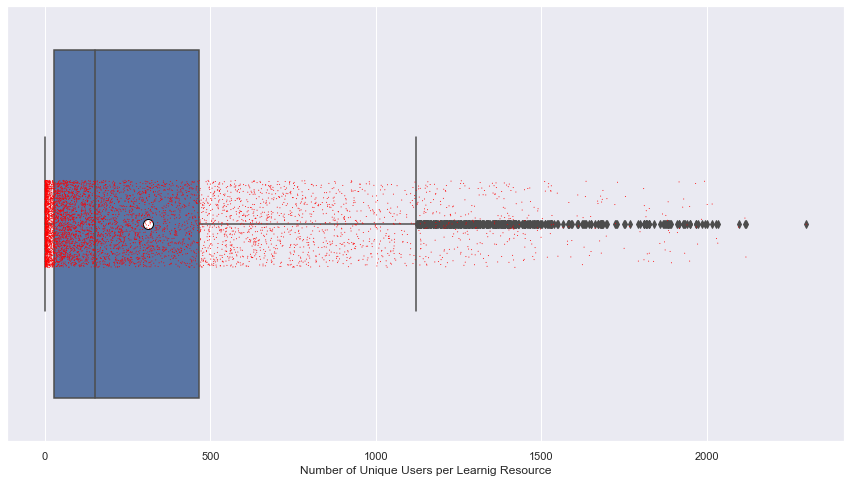

In [40]:
g = sns.boxplot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, size=1, color="red");
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR);

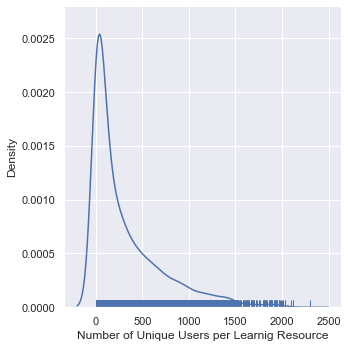

In [41]:
g = sns.displot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR);

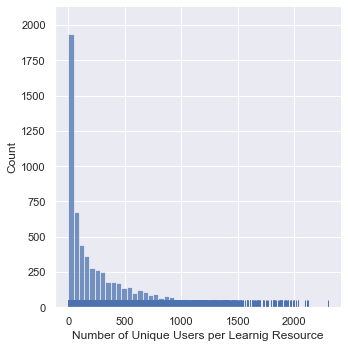

In [42]:
g = sns.displot(data=n_unique_users_per_learning_activity, x=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR, log_scale=False, kind='hist', rug=True)
g.set(xlabel=NUMBER_UNIQUE_USERS_PER_LEARNING_ACTIVITY_STR);

### Avg Number of Interactions over Groups for a User (User Sequence Length)

In [43]:
mean_n_interactions_over_groups, median_n_interactions_over_groups = print_and_return_avg_num_interactions_over_col2_for_col1(interactions, USER_FIELD, GROUP_FIELD, MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR)

mean of Mean Number of Interactions over Topics for a User: 329.42044501546866
median of Mean Number of Interactions over Topics for a User: 215.0
max of Mean Number of Interactions over Topics for a User: 2947.0
min of Mean Number of Interactions over Topics for a User: 1.0

__________________________________________________

mean of Median Number of Interactions over Topics for a User: 329.1476183170975
median of Median Number of Interactions over Topics for a User: 214.0
max of Median Number of Interactions over Topics for a User: 2947.0
min of Median Number of Interactions over Topics for a User: 1.0


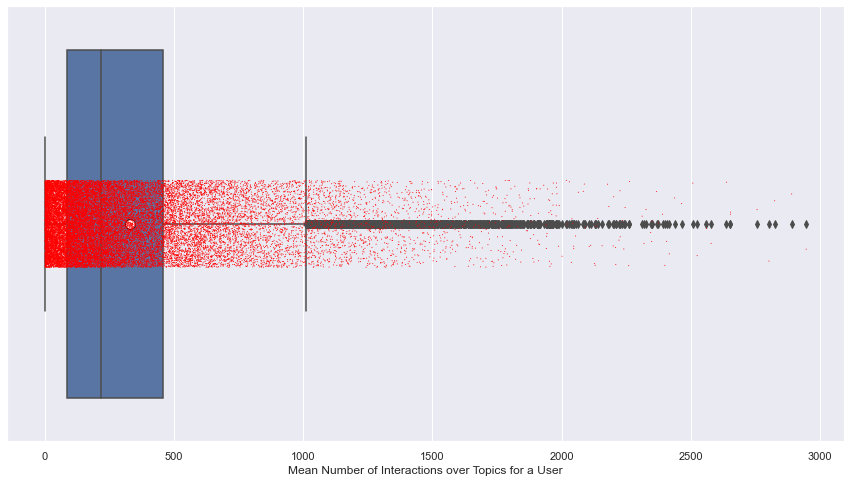

In [44]:
g = sns.boxplot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

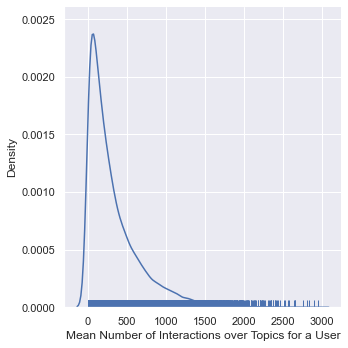

In [45]:
g = sns.displot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

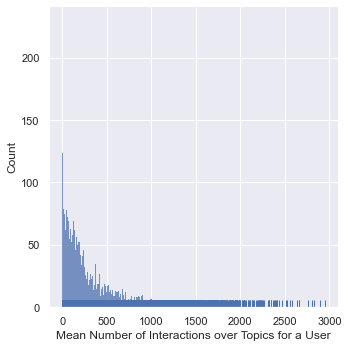

In [46]:
g = sns.displot(data=mean_n_interactions_over_groups, x=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

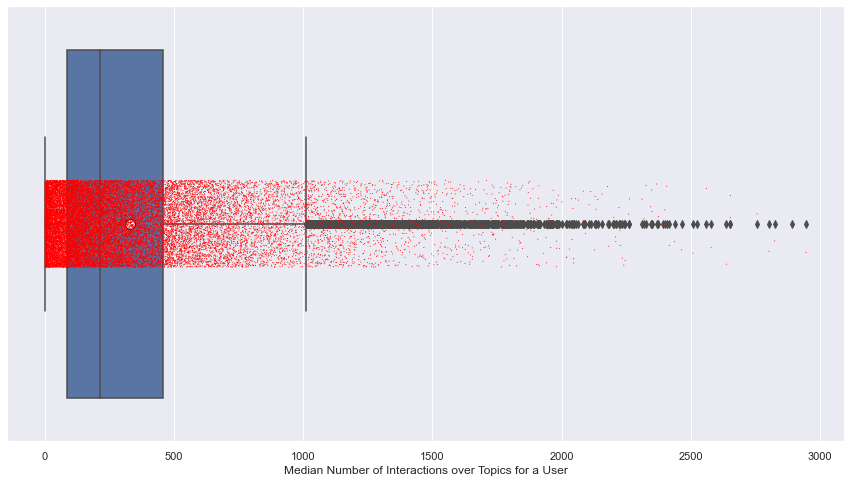

In [47]:
g = sns.boxplot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

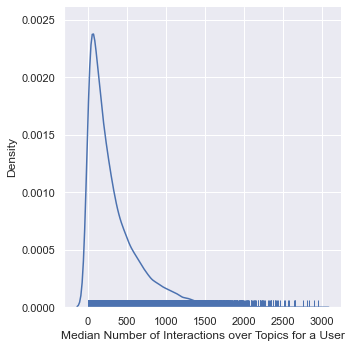

In [48]:
g = sns.displot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

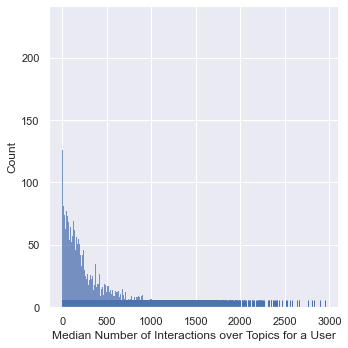

In [49]:
g = sns.displot(data=median_n_interactions_over_groups, x=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_GROUPS_FOR_USER_STR);

### Avg Number of Interactions over Users for a Group (Group Sequence Length)

In [50]:
mean_n_interactions_over_users, median_n_interactions_over_users = print_and_return_avg_num_interactions_over_col2_for_col1(interactions, GROUP_FIELD, USER_FIELD, MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR)

mean of Mean Number of Interactions over Users for a Topic: 317.7654056295453
median of Mean Number of Interactions over Users for a Topic: 310.8336099849188
max of Mean Number of Interactions over Users for a Topic: 582.1801324503311
min of Mean Number of Interactions over Users for a Topic: 132.33764553686933

__________________________________________________

mean of Median Number of Interactions over Users for a Topic: 243.86363636363637
median of Median Number of Interactions over Users for a Topic: 233.0
max of Median Number of Interactions over Users for a Topic: 492.0
min of Median Number of Interactions over Users for a Topic: 111.0


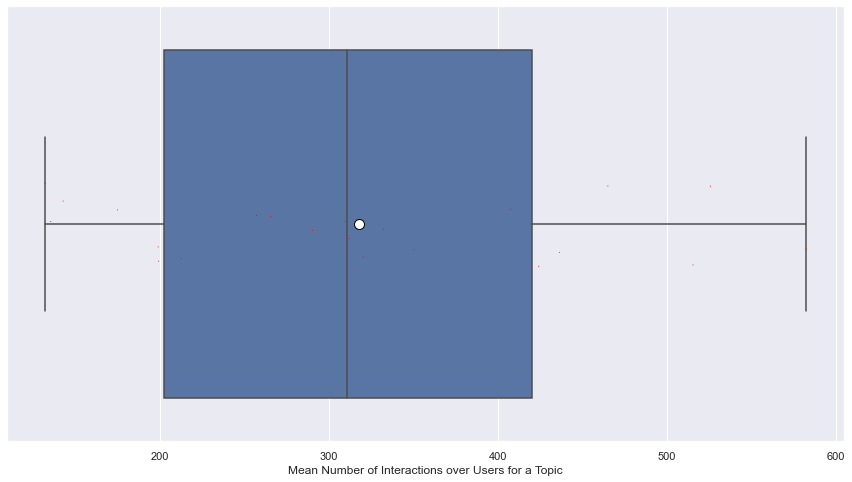

In [51]:
g = sns.boxplot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

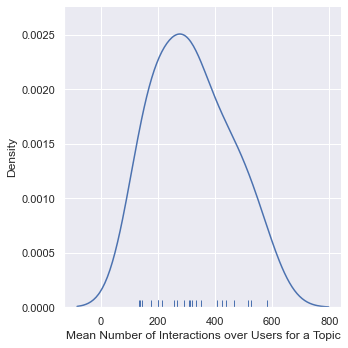

In [52]:
g = sns.displot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

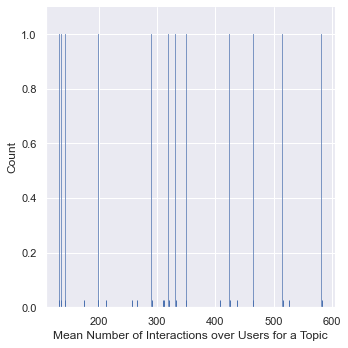

In [53]:
g = sns.displot(data=mean_n_interactions_over_users, x=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

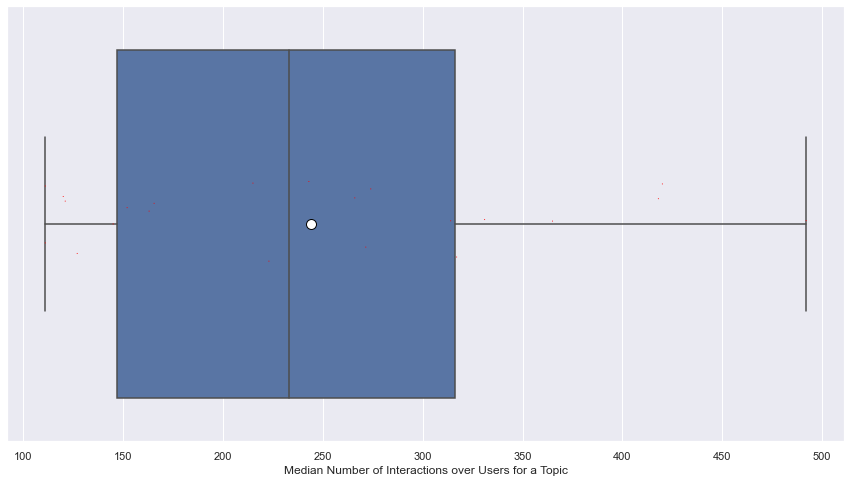

In [54]:
g = sns.boxplot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

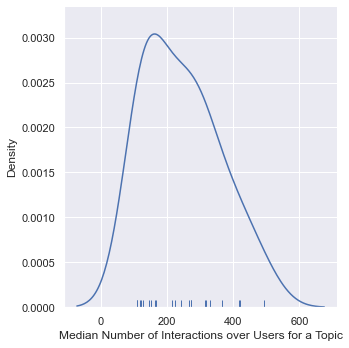

In [55]:
g = sns.displot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

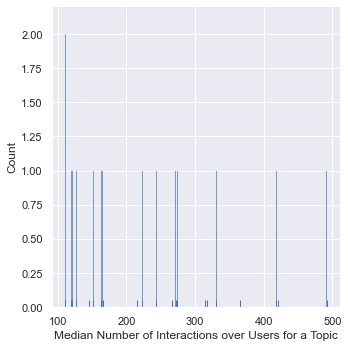

In [56]:
g = sns.displot(data=median_n_interactions_over_users, x=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_INTERACTIONS_OVER_USERS_FOR_GROUP_STR);

### Avg Number of Unique Learning Activities over Groups for a User

In [57]:
mean_n_unique_learning_activities_over_groups_for_user, median_n_unique_learning_activities_over_groups_for_user = print_and_return_avg_num_unique_col3_over_col2_for_col1(interactions, USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD, MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR)

mean of Mean Number of Unique Learnig Resources over Topics for a User: 67.93728618547212
median of Mean Number of Unique Learnig Resources over Topics for a User: 52.0
max of Mean Number of Unique Learnig Resources over Topics for a User: 413.0
min of Mean Number of Unique Learnig Resources over Topics for a User: 1.0

__________________________________________________

mean of Median Number of Unique Learnig Resources over Topics for a User: 67.89288179795966
median of Median Number of Unique Learnig Resources over Topics for a User: 52.0
max of Median Number of Unique Learnig Resources over Topics for a User: 413.0
min of Median Number of Unique Learnig Resources over Topics for a User: 1.0


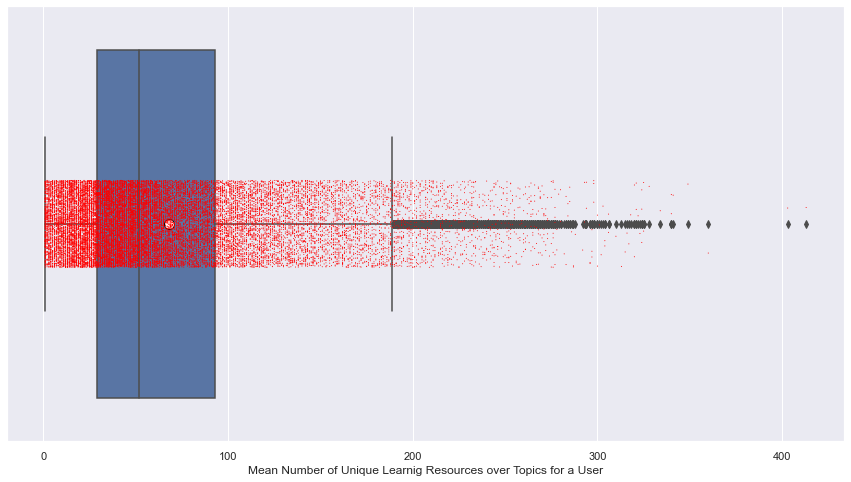

In [58]:
g = sns.boxplot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

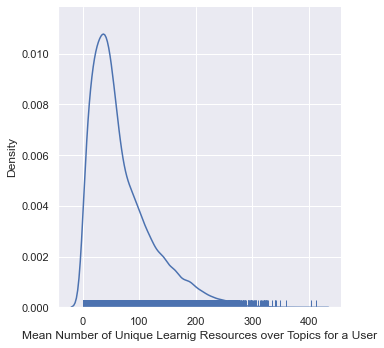

In [59]:
g = sns.displot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

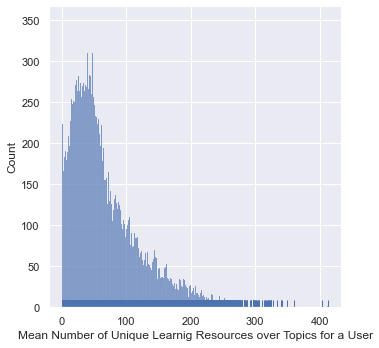

In [60]:
g = sns.displot(data=mean_n_unique_learning_activities_over_groups_for_user, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

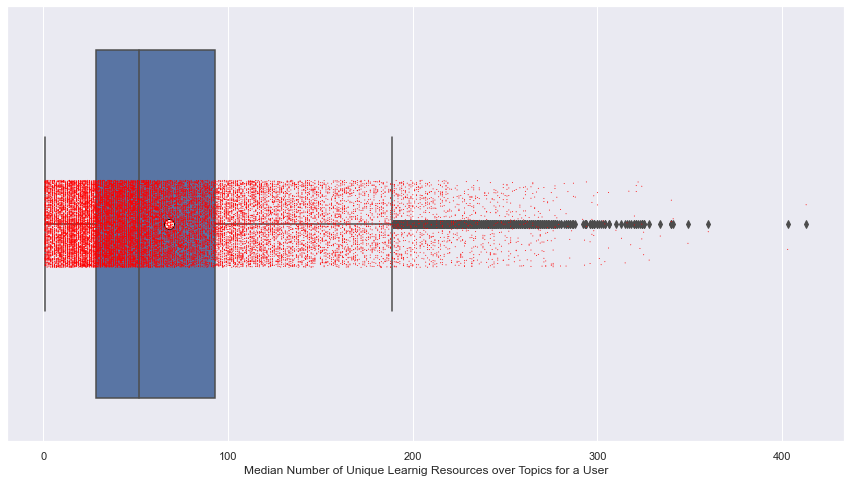

In [61]:
g = sns.boxplot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

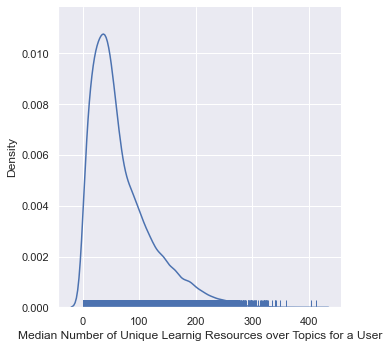

In [62]:
g = sns.displot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

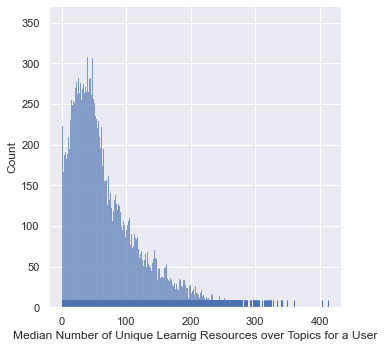

In [63]:
g = sns.displot(data=median_n_unique_learning_activities_over_groups_for_user, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_GROUPS_FOR_USERS_STR);

### Avg Number of Unique Learning Activities over Users for a Group

In [64]:
mean_n_unique_learning_activities_over_users_for_group, median_n_unique_learning_activities_over_users_for_group = print_and_return_avg_num_unique_col3_over_col2_for_col1(interactions, GROUP_FIELD, USER_FIELD, LEARNING_ACTIVITY_FIELD, MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR)

mean of Mean Number of Unique Learnig Resources over Users for a Topic: 62.82079408070283
median of Mean Number of Unique Learnig Resources over Users for a Topic: 53.19592258683687
max of Mean Number of Unique Learnig Resources over Users for a Topic: 121.0225165562914
min of Mean Number of Unique Learnig Resources over Users for a Topic: 31.208279430789133

__________________________________________________

mean of Median Number of Unique Learnig Resources over Users for a Topic: 60.18181818181818
median of Median Number of Unique Learnig Resources over Users for a Topic: 52.0
max of Median Number of Unique Learnig Resources over Users for a Topic: 113.0
min of Median Number of Unique Learnig Resources over Users for a Topic: 31.0


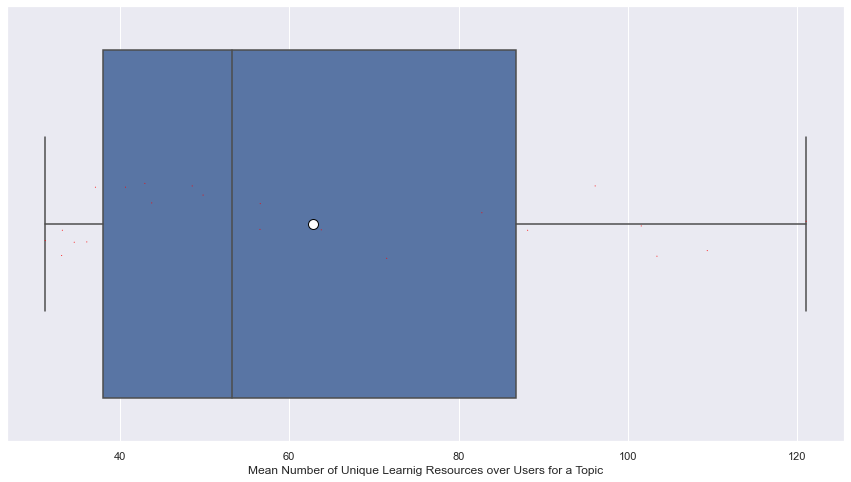

In [65]:
g = sns.boxplot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, size=1, color="red");
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

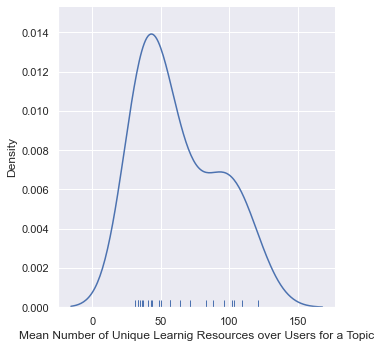

In [66]:
g = sns.displot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

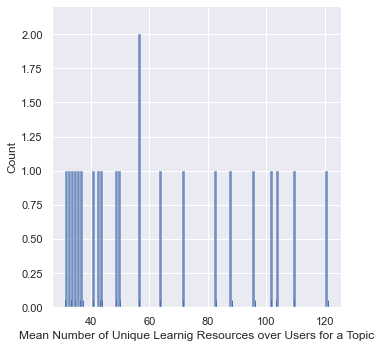

In [67]:
g = sns.displot(data=mean_n_unique_learning_activities_over_users_for_group, x=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

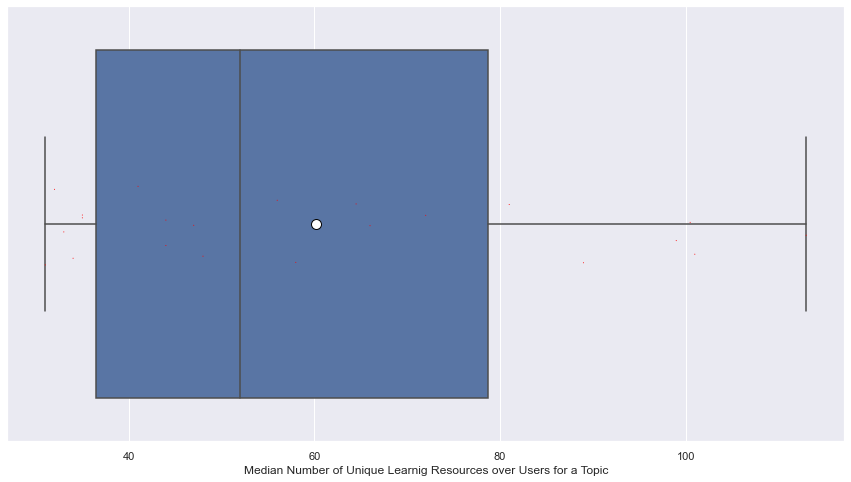

In [68]:
g = sns.boxplot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, size=1, color="red");
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

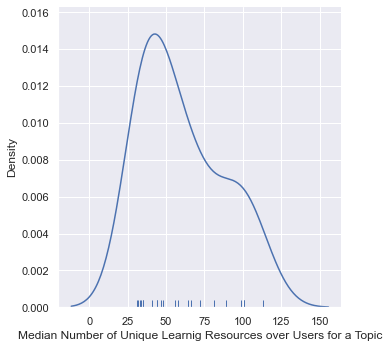

In [69]:
g = sns.displot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='kde', rug=True)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

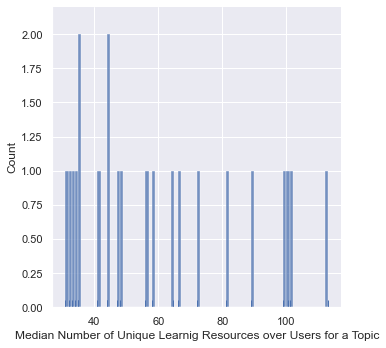

In [70]:
g = sns.displot(data=median_n_unique_learning_activities_over_users_for_group, x=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR, log_scale=False, kind='hist', rug=True, binwidth=1)
g.set(xlabel=MEDIAN_NUMBER_UNIQUE_LEARNING_ACTIVITIES_OVER_USERS_FOR_GROUPS_STR);

### Sparsity - User_Item_Matrix

#### User-Group

In [71]:
sparsity = calculate_sparsity(interactions[USER_FIELD], interactions[GROUP_FIELD])
print(f"User-{GROUP_FIELD_NAME_STR} Sparsity: {sparsity} %")

User-Topic Sparsity: 94.90471176441875 %


#### User-Learning Activity

In [72]:
sparsity = calculate_sparsity(interactions[USER_FIELD], interactions[LEARNING_ACTIVITY_FIELD])
print(f"User-{LEARNING_ACTIVITY_FIELD_NAME_STR} Sparsity: {sparsity} %")

User-Learning Resource Sparsity: 98.80041973708035 %


## Unique Sequence Statistics

### Unique User Sequence Statistics per Group

In [ ]:
learning_activity_sequence_stats_per_group = return_col3_sequence_stats_over_col2_per_col1(interactions, 
                                                                                           GROUP_FIELD, 
                                                                                           USER_FIELD, 
                                                                                           LEARNING_ACTIVITY_FIELD,
                                                                                           TIMESTAMP_FIELD,
                                                                                           GROUP_FIELD_NAME_STR,
                                                                                           GROUP_CODE_FIELD_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                                           UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                                                                                           LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR)

In [ ]:
plot_sequence_stats_per_group(learning_activity_sequence_stats_per_group,
                              GROUP_CODE_FIELD_NAME_STR, 
                              LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                              UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_PCT_PER_GROUP_TITLE_NAME_STR,
                              LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_PER_GROUP_TITLE_NAME_STR,
                              LEARNING_ACTIVITY_UNIQUE_VS_TOTAL_NUMBER_OF_SEQUENCES_PER_GROUP_TITLE_NAME_STR)

### Unique User Sequence Statistics

In [ ]:
learning_activity_sequence_stats = return_col2_sequence_stats_over_col1(interactions, 
                                                                        USER_FIELD, 
                                                                        LEARNING_ACTIVITY_FIELD,
                                                                        TIMESTAMP_FIELD,
                                                                        LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                        UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                                                                        LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR)

In [ ]:
plot_sequence_stats(learning_activity_sequence_stats,
                    LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                    UNIQUE_LEARNING_ACTIVITY_SEQUENCE_COUNT_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_FREQUENCY_PCT_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_LENGTH_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_PCT_TITLE_NAME_STR,
                    LEARNING_ACTIVITY_SEQUENCE_LENGTH_VS_FREQUENCY_TITLE_NAME_STR,
                    LEARNING_ACTIVITY_UNIQUE_VS_TOTAL_NUMBER_OF_SEQUENCES_TITLE_NAME_STR)

## Sequence Distance

### Sequence Distance between Users per Group

In [ ]:
seq_sim = SeqSim(interactions.head(100000), USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD)

In [ ]:
seq_dist_per_group_dict = seq_sim.get_user_sequence_distances_per_group(td.levenshtein.distance, sample_pct=80, sample_pct_user=10)

In [ ]:
with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PER_GROUP_PICKLE_NAME, 'wb') as f:
    pickle.dump(seq_dist_per_group_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
avg_seq_dist_per_group_df = get_avg_seq_dist_per_group_df(seq_dist_per_group_dict)

In [ ]:
avg_seq_dist_per_group_df

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='mean_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='mean_distance', size=5, color="red");
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_mean_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='median_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='median_distance', size=5, color="red");
g.set(xlabel=f'Median Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_median_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='mean_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='median_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Median Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', size=5, color="red");
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_mean_normalized_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.boxplot(data=avg_seq_dist_per_group_df, x='median_normalized_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=avg_seq_dist_per_group_df, x='median_normalized_distance', size=5, color="red");
g.set(xlabel=f'Median Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_median_normalized_seq_dist_per_group.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.displot(data=avg_seq_dist_per_group_df, x='median_normalized_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Median Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_distance', y='mean_user_sequence_length')
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Sequence Length per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', y='mean_user_sequence_length')
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Sequence Length per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_distance', y='mean_max_seq_length_per_group')
g.set(xlabel=f'Mean Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Max Sequence Length per {GROUP_FIELD_NAME_STR}');

In [ ]:
g = sns.regplot(data=avg_seq_dist_per_group_df, x='mean_normalized_distance', y='mean_max_seq_length_per_group')
g.set(xlabel=f'Mean Normalized Sequence Distance per {GROUP_FIELD_NAME_STR}', ylabel=f'Mean Max Sequence Length per {GROUP_FIELD_NAME_STR}');

### Sequence Distance between Users 

In [ ]:
seq_sim = SeqSim(interactions.head(50000), USER_FIELD, GROUP_FIELD, LEARNING_ACTIVITY_FIELD)

In [ ]:
seq_dist_dict = seq_sim.get_user_sequence_distances(td.levenshtein.distance, sample_pct=20)

In [ ]:
with open(PATH_TO_PICKLED_OBJECTS_FOLDER + DATASET_NAME + SEQUENCE_DISTANCE_DICT_PICKLE_NAME, "wb") as f:
    pickle.dump(seq_dist_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
seq_dist_df = get_seq_dist_df(seq_dist_dict)

In [ ]:
seq_dist_df

In [ ]:
g = sns.boxplot(data=seq_dist_df, x='distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=seq_dist_df, x='distance', size=5, color="red");
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_seq_dist_per_user_combination_pair.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=seq_dist_df, x='distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.boxplot(data=seq_dist_df, x='normalized_distance', showmeans=True, meanprops=marker_config);
g = sns.stripplot(data=seq_dist_df, x='normalized_distance', size=5, color="red");
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');
plt.savefig(PATH_TO_PLOT_FOLDER + DATASET_NAME + '_normalized_seq_dist_per_user_combination_pair.png', dpi=300, bbox_inches='tight')

In [ ]:
g = sns.displot(data=seq_dist_df, x='normalized_distance', log_scale=False, kind='kde', rug=True)
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='distance', y='mean_user_sequence_length_per_combination')
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Mean Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='normalized_distance', y='mean_user_sequence_length_per_combination')
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Mean Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='distance', y='max_user_sequence_length_per_combination')
g.set(xlabel=f'Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Max Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');

In [ ]:
g = sns.regplot(data=seq_dist_df, x='normalized_distance', y='max_user_sequence_length_per_combination')
g.set(xlabel=f'Normalized Sequence Distance per {USER_FIELD_NAME_STR}-Combination Pair', ylabel=f'Max Sequence Length per {USER_FIELD_NAME_STR}-Combination Pair');